---
# LU3IN025 Projet IA et Jeux 2021
# ***Cooperative path-finding***
Loi Alessia, Moulouel Myriem, Groupe 3

---

# I. Objectifs et méthodes de résolution implementées

Objectif du projet : dans un univers de N agents, partagés en 2 équipes de N/2 joueurs, trouver un ensemble de chemins, sans collisions, permettant à chaque agent d'atteindre sa destination. En suite, comparer les performances des differentes strategies.

Version adversariale: N équipes d'agents sont en compétition et cherchent à atteindre leurs destinations avant leurs adversaires. Consignes: N=2, chaque agent a un objectif unique, différent pour chaque agent.


**Règles:**


---


*   Un joueur peut faire une pause dans son déplacement, (reste sur sa case sans bouger).
*   Nombre de tours du jeu fixé pour éviter les situations de blocage.
*   Les actions au sein de chaque équipe peuvent être cordonnées.


*Déplacement:*


    1.   Les tours alternent entre équipes: les agents de l'équpe Apeuvent tous bouger, puis ceux de l'équipe B
    2.   Les agents de déplacent sur une case adjacente ou restent au même endroit
    3.   Éviter toute collision: un agent se déplace vers une case si celle-ci est libre ou libérée dans le même tour par un joueur de la même équipe.
    4.   L'échange de positions entre 2 agents n'est oas permis.
*   Les positions des agents (équipiers et adversaires) et des objectifs aux autres agents, ce n'est pas le cas pour les agents de l'autre équipe.













**Critères de victoire:**


---


*   L'équipe gagnante est celle qui a placé le plus d'agents à leur destination.
*   En cas d'égalité, l'équipe gagnante est celle dont la somme des pas du chemin des agents arrivés à destination est la plus petite.
*   Il est possible de déplacer une équipe victorieuse même si toutes les destinations ne sont pas atteintes.



**Code fourni:**


---

*   *pySpiriteWorld* : gestion des personnages et des cartes (CODE À NE PAS MODIFIER), les cartes sont organisées en layers: layer joueur, layer ramassable (objets), layer obstacle.
*   *repertoire search* : algorithmes de résolution (Probleme.py)
*   *main.py* : exemple de code ("A* cooperative" versus "MinMax")



Nous avons implementé les strategies suivantes:

*   Local Repair A*

    A* indépendants au sein d'une équipe, recalcul du chemin en cas de collision avec co-équipiers ou adversaires


*   Collaborative Pathfinding with A*

    A* au sein d'une équipe, et chaque joueur calcule son chemin en évitant les collisions avec les co-équipiers

*   MinMax

    MinMax consiste à maximiser le gain minimum au sein d'une équipe, en prevoyant le coup de l'équipe adversaire, qui va surement essayer de minimiser les gains de cette équipe!


Pour effectuer les tests, nous avons modifié plusieures maps JSON:

* init('map1_2equipes_2joueurs')
* init('map1_2equipes_5joueurs')
* init('map2_2equipes_1joueur')
* init('map2_2equipes_2joueurs')
* init('map2_2equipes_3joueurs')
* init('map2_2equipes_5joueurs')
* init('map2_2equipes_10joueurs')


# II. Structure du programme

Le fichier main.py contient l'initialisation des équipes et la boucle des iterations de jeu.
1. Nous avons partagé les informations contenues dans les listes initStates et goalStates (générées à partir du file JSON) en 2 groupes, l'un pour l'équipe Bleue et l'autre pour l'équipe Rouge.
> initStates ---->  initStates_equipeB, initStates_equipeR
> goalStates ---->  objectifs_equipeB, objectifs_equipeR

2. Nous avons instantiancé autant de ProblemeGrid2D que de nombre d'agents, et on les a partagés dans 2 listes equipeB et equipeR.

3. Trois variables globales LOCAL_REPAIR, COLLAB_PATH_FINDING et MINMAX permettent d'éxecuter la strategie souhaitée pour une équipe.

4. La boucle des iterations de jeu contient le code pour déplacer les équipes. Les équipes jouent sequentiellement : d'abord il se deplacent tous les agents de l'équipe BLEUE, en suite ceux de l'équipe ROUGE.

5. Les strategies sont implementées dans le fichier *probleme.py*, et leur fonctions sont appelées par l'équipe concernée depuis le *main.py*. Toute strategie retourne la liste des positions à effectuer *posPlayersB* ou *posPlayersR* pour l'iteration courante du jeu.

6. Un test en fin de boucle permet de vérifier si la dernière configuration de positions retournée par une strategie a produit l'obtention d'un nouveau objectif dans l'iteration du jeu  et donc l'incrementation du score.

7. Dès qu'une équipe gagne ou dès que le seuil maximum d'iterations a été executé, alors le jeu s'arrete et on compare les scores de chaque équipe pour décreter le gagnant.

Separé par rapport au *main.py*, nous avons ajouté un nouveau fichier chargé d'executer plusieures fois automatiquement le main et ainsi collecter les données statistiques. 


# III. Strategies et observations

## Local Repair A*

**Description générale**

---

L'algorithme "Local Repair A*" permet à chaque agent au sein d'une équipe de trouver le plus court chemin jusqu'à une destination donnée en utilisant A*, et ensuite gérer les collisions eventuelles avec les voisins directs de la case courante.
Chaque agent calcule son chemin independemment, sans s'accorder ni tenir compte des chemins des autres agents. Une fois le chemin calculé, l'agent le suit case après case, tant qu'il n'y a pas de collision avec un autre agent. Dans ce dernier cas, l'agent re-calcule un nouveau chemin en évitant la case occupée par l'autre agent participant à la collision.

**Implementation**

    localRepair_astar(equipe,posPlayersEquipe,posPlayersAdv,scoreEquipe,verbose=False,stepwise=False)**

---
1. En fonction du remplissage du tableau des scores de l'équipe, on ne traite que les joueurs qui ne sont pas encore arrivés à leur objectif (score[\joueur]=0). Les joueurs ainsi selectionnées seront répresentés par un chiffre dans une liste *joueursEnAttente*.

2. On itére sur la liste joueursEnAttente. Pour chaque joueur, on teste si il y a déjà un chemin path pre-calculé en memoire : dans la structure de données ProblemeGrid2D associée à chaque joueur, nous avons ajouté un champ *self.path* contenant le path à effectuer, i.e la liste de cases (x,y) à partir de l'état courant jusqu'à l'état objectif. Ce champ permettera à chaque agent de reprendre son chemin sans le recalculer. En debut de jeu la liste path est vide, donc on initialise la liste avec le chemin calculé par A*.

3. On traite la première case de la liste *path* : normalement c'est notre prochain pas. On teste si la case est déjà occupée par un membre de notre équipe ou sinon un adversaire. Selon le cas, on agit differemment:

  3a. Gestion des collisions 1 : la case (row,col) choisie est occupée par un joueur de notre équipe. Principe : mon co-équipier ne cherchera pas à me bloquer exprès, donc pour moi il est mieux d'attendre un tour de jeu et maintenir mon chemin optimal à la place de le recalculer et modifier. En détail, il y a donc 2 cas possibles:
  * le joueur qui occupe ma case a déjà joué --> le joueur courant fait une pause = il ne se deplace pas dans ce tour de jeu. Dans ce cas il est notifié en affectant la valeur True à la variable *joueurBloqueParAmi*
  * le joueur qui occupe ma case doit encore jouer --> on place le joueur courant en fin de liste joueursEnAttente, pour voir si la case se libère autretemps.

  3b. Gestion des collisions 2 : la case (row,col) choisie est occupée par un joueur de l'équipe adversaire. Principe : en ne connaissant pas les intentions de mon adversaire (simple passage ou blocage volontaire?), il est mieux de trouver de suite un nouveau chemin pour m'éloigner de son perimetre et lui empecher d'autres blocages. En détail, il y a 2 cas possibles:
  * tant qu'il y a d'autres cases accessibles autour du joueur (liste facteurBr) ---> le joueur cherche un nouveau path
  * si il n'y a plus de cases accessibles ---> le joueur courant fait une pause = il ne se deplace pas dans ce tour de jeu. Dans ce cas il est notifié en affectant la valeur True à la variable *joueurBloqueParEnnemi*

4. Si la case choisie n'est pas occupée par un co-équipier ou un adversaire, alors la case choisie est valide et le joueur peut affecter la liste *posPlayersEquipe* à retourner. Sinon, la case est replacé en tete de liste de *path* car il ne le "consomme" pas (= ne fait aucun déplacement) pour l'iteration en cours.

**Observations**

---

L'algorithme apparait rapide et efficace. Chaque agent calcule son plus court chemin avec A* et si le plan de jeu est peu dense cela suffit pour avoir des chemins optimaux et arriver rapidement à destination. Justement, les défauts de cette approche apparaissent et s'accentuent en fonction du nombre de joueurs et de la densité en obstacles.

* La reparation de collision est seulement locale, donc un agent ne peut pas éviter les autres agents avant de se retrouver sur une case adjacente. Cela veut dire que toute collision constituira un retard, une prolungation d'un chemin optimal, ce qui augmente les pas nécessaires pour arriver à l'objectif.

* L'implementation choisie pour la gestion de collisions 1 (celle avec un co-équipier) peut créer des interblocages. En effet, si 2 agents j1 et j2 d'une meme équipe veulent se deplacer en direction opposée (ex : vers le nord, vers le sud) et collident autour de 2 cases adjacents, les 2 vont se placer en fin de liste *joueursEnAttente* le temps que l'autre équipier ne libère le passage, en créant ainsi une attente mutuelle.
Pour regler cela, on a ajouté une variable *preventLoop* qui autorise une utilisation de tel mecanisme pour un nombre limité de fois et donc empêche de boucler indefiniment. Une fois depassées les iterations *preventLoop*, les co-equipiers essaient de se liberer en calculant un nouveau chemin A*.

* On a remarqué que un petit nombre de collisions peut amener à des boucles du parcours qui concernent plusieurs agents. Par exemple, l'image ci-dessous est tirée d'une instance avec 10 agents dans le map dense : l'agent entouré en jaune repetait deux chemins, l'un en direction du personnage entouré en rouge en haut et l'autre en direction du personnage entouré en rouge en bas.
A chaque iteration, le personnage en jaune entrait en collision avec le personnage entouré en rouge en haut, après celui en bas, celui en haut...

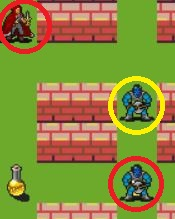

* Il est possible pour un agent de rester bloqué dans une impasse, fermé sur les ouvertures par des agents qui ont presque en même temps rejoint leurs objectifs. L'agent réagit en calculant A* à chaque nouveau step, sans détecter que tout chemin ne pourra pas le sortir de l'impasse.

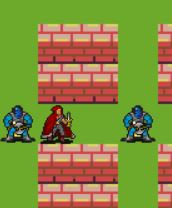

* Contrairement à A*, Local Repair A* permet de parcourir les mêmes cases plusieurs fois. Il n'y a pas de limites au nombre de visites sur une même case, et cela implique une information nulle sur l'environnemment déjà parcouru.

Vu que la detection de la collision ne peut arriver que au niveau locale, cette approche ne permet pas d'évaluer une zone plus large de 8 carreau autour d'un joueur. Le resultat dependera completement du nombre de collision rencontrées sur son propre chemin et aussi du risque de boucles ou blocages representé par un nombre élevé d'agents et un map dense.
De plus, il n'y a aucune communication entre agents d'une même équipe, ce qui ne favorise pas des strategies collaboratives de detection ou action. 






## Collaborative Pathfinding with A*
**Description générale**

---

**Implementation**

    collaborativePathfinding(equipe,posPlayersEquipe,posPlayersAdv,objectifsEquipe,initStatesEquipe,scoreEquipe,verbose=False,stepwise=False)

    collaborativePath(p,reservationTable,verbose=False,stepwise=False)

    freeExCollaborativePath(p,reservationTable,verbose=False,stepwise=False)


---

L'algorithme "Collaborative Pathfinding with A*\" permet à chaque agent au sein d'une équipe de calculer son propre chemin avec A* en prenant en compte les chemins déjà contituées par les autres co-équipiers, de manière à eviter toute collision parmi eux. Cela est possible grâce à un système de reservations des cases répresenté par une structure de données en 3 dimensions (x, y, temps) qui assure le passage d'un seul agent sur la case (x,y) au moment t. L'agent interessé à une case déjà reservée, attendra le temps necessaire pour qu'elle se libère, en réservant la même case à un creneau successif disponible.

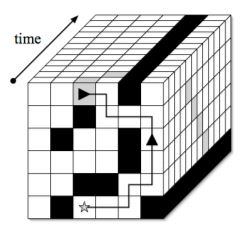

---

*Image : Cooperative Pathfinding, David Silver, University of Alberta*

---
1. En fonction du remplissage du tableau des scores de l'équipe, on ne traite que les joueurs qui ne sont pas encore arrivés à leur objectif (score[\joueur]=0). Les joueurs ainsi selectionnées seront répresentés par un chiffre dans une liste *joueursEnAttente*.

2. On itère sur la liste *joueursEnAttente*. Pour chaque joueur, on teste si il y a déjà un chemin path pre-calculé en memoire : dans la structure de données ProblemeGrid2D associée à chaque joueur, nous avons ajouté un champ *self.path* contenant le path à effectuer, i.e la liste de cases (x,y) à partir de l'état courant jusqu'à l'état objectif. Ce champ permettra à chaque agent de reprendre son chemin sans le recalculer. En debut de jeu la liste path est vide, donc on initialise la liste en appelant la fonction *collaborativePath*.

3. *collaborativePath* retourne un chemin qui ne collide pas avec les chemins des autres joueurs au sein de la même équipe. La fonction calcule un chemin A*\, ensuite, pour chaque case de ce chemin elle teste si la case correspondante est libre ou réservée au moment t. La structure de réservation est implementée à l'aide d'un dictionnaire *reservationTable*, dont les clés sont des tuples (x,y,t) et les valeurs sont des booleens indiquant l'état de la réservation (True : case réservée au moment t; False : case libre au moment t). 
Si la case recherchée n'est pas disponible, le joueur doit attendre sur la case precedente tant que le passage se libère.

4. Les collisions entre co-équipiers normalement ne doivent pas se produire, sauf si la case occupée est une case objectif et l'autre agent l'a rejoint avant notre passage. Dans ce cas, l'autre agent ne va surement pas se deplacer: on recalcule donc le chemin.

5. Gestion des collisions : la case (row,col) choisie est occupée par un joueur de l'équipe adversaire. Principe : en ne connaissant pas les intentions de mon adversaire (simple passage ou blocage volontaire?), il est mieux de trouver de suite un nouveau chemin pour m'éloigner de son perimetre et lui empecher d'autres blocages. En détail, il y a 2 cas possibles:
  * tant qu'il y a d'autres cases accessibles autour du joueur (liste facteurBr) ---> le joueur cherche un nouveau path, en appelant la fonction *collaborativePath*
  * si il n'y a plus de cases accessibles ---> le joueur courant fait une pause = il ne se deplace pas dans ce tour de jeu. Dans ce cas il est notifié en affectant la valeur True à la variable *joueurBloqueParEnnemi*
  
  NB. En cas de recalcul de chemin, on utilise la fonction *freeExCollaborativePath* afin de rendre l'ancien path du joueur à nouveau disponible pour les autres joueurs de l'équipe dans le dictionnaire *reservationTable*

6. Si la case choisie n'est pas occupée par un co-équipier ou un adversaire, alors la case choisie est valide et le joueur peut affecter la liste *posPlayersEquipe* à retourner. Sinon, la case est replacé en tete de liste de *path* car il ne la "consomme" pas (= ne fait aucun déplacement) pour l'itération en cours.

**Observations**


1. Si un joueur croise un co-équipier, il attend que ce dernier soit passé. Au contraire, si il croise un joueur de l'équipe adversaire, il récalcule son chemin. Cela implique que, par rapport au Local Repaire A*\, le joueur changera moins souvent son chemin optimale, en préférant d'effectuer des pauses.

2. Si deux co-équipiers se croisent en directions opposées, ils vont se rencontrer à la moitié du chemin et avoir une collision. Cette strategie assure que les cases sont libres au moment t, mais ne peut pas identifier l'appartenance à un parcours de chaque case. En effet, le dictionnaire montre si la case (x, y, t) est libre au moment t, mais n'indique pas à quel joueur elle est attribuée, à quelle chemin elle appartient, ni dans quelle direction elle sera empruntée.

3. On remarque que souvent les co-équipiers suivent le même parcours à une case de distance et cela ne pose évidemment pas de soucis.

4. Si il y a beaucoup de joueurs, les temps d'attente peuvent augmenter considérablement et ralentir l'avancée générale de l'équipe.



## MinMax
**Explication de MinMax**


---


*À information complète

Pour une équipe donnée de n joueurs, pour chaque joueur, on trouve les coups valides (les cordonnées des cases dans lesquelles il pourrait se déplacer), maximum c'est 4 cases et avec la possibilité de rester sur place on y rajoute la case courante, donc au plus, 5 cases pour chaque joueurs, on exclue les cases où se trouve les obstacles, les joueurs adverses et les autres joueurs de la même équipe.

l'idée est de réussire à trouver la combinaison des cases des joueurs de cette équipe (des situations) qui maximise le gain minimum jusqu'à une profondeur donnée.


*   **minmax(pere) = max(min(fils1), min(fils2), ...min(filsn))**

pere est le noeud(pos1, 0, None) des joueurs dans la liste des positions pos1 avec des fils fils1, fils2, ..., filsn;

ainsi 
*   **min(fils1) = min(max(fils1'), max(fils2'), ..., max(filsk'))**



où fils est le neoud(pos2, 0, pere) des joueurs adverses dans les positions pos2 dont le pere est pere, avec les fils fils1', fils2', ..., filsk'



**Explication de code:**

---

la fonction *MinMax* qui prend en paramètre la grille du jeu (matrice), les deux équipes, leurs positions, leurs objectifs et la profondeur souhaitée, verbose=True si on veut les affichages, stepwise=True si on veut controler les itérations

```
MinMax(g, equipe1, equipe2, position1, position2, depth, verbose=False, stepwise=False)

```
crée un noeud pere, qui contient toutes les positions de tous les joueurs (l'etat de la grille)

la fonction cherche les combinaisons valides possibles pour equipe1 (les positions de chacun de ses joueurs), pour celà elle fait appel à la fonction *coup_valide* qui renvoie une liste des listes des coups valides pour chaque joueur en evitant les obstacles, les cases où se trouvent les adversaires et les autres joueurs de la même équipe => éviter les collisions avec les adversaires
```
coup_valide_par_joueur = coups_valides(g, equipe1, equipe2, position1, position2)
```
ainsi avec la fonction *ensemble_coup* celle ci va donner toutes les combinaisons valides pour l'equipe (ça se rapproche du produit cartesien)
```
liste = ensemble_coup(coup_valide_par_joueur)
```
On applique une méthodes pour éviter les collisions en prenant les combinaisons dans lesquelles toutes les positions des joueurs sont differentes => pas de collision avec les collègues

Donc quand on aura toutes les situations suivantes possible pour l'équipe, on regarde pour chaque situation celle avec un gain maximal
```
for coups in l_coups_valides:
  .
  .
  .
```
pour celà, on crée un noeud pour chaque situation en le reliant au noeud pere, et on choisit le noeud qui maximisera les gains de l'équipe,

donc on cherche l'évalution la plus grande (la maximum) qui minimisera les gains

pour celà on fait appel à *minValue*:

```
val = minValue(noeud_impair, [coups,position2], g, equipe1, equipe2, depth)
```

**minValue**

va chercher pour l'adversaire (equipe2) la situation  qui minimisera le gain de equipe1, et renvoie son evaluation.


1.   si la profondeur == 1:

on renvoie l'evaluation de la situation avec l'appel de Evaluation
```
evalu = Evaluation(noeud.etat, equipe1, equipe2)
```
2.   Sinon:

pour chaque liste de coups valides pour l'equipe2, renvoie l'estimation la plus petite qui maximisera le gain de equipe1, donc elle appelle la fonction *maxValue* avec une profondeur-1 par rapport à la profondeur initiale
```
val = maxValue(noeud_pair, [coup[0],coups], g, equipe1, equipe2, depth-1)
```


**maxValue**

va chercher pour l'equipe1 la situation qui maximisera le gain de equipe1, et renvoie son evaluation.


1.   Si profondeur == 1:
on renvoie l'evaluation de la situation avec l'appel de Evalution
```
return Evaluation(noeud.etat, equipe1, equipe2)
```
2.   Sinon:

pour chaque liste des coups valides pour equipe1, renvoie l'estimation la plus grande qui minimisera le gain de equipe1, donc elle appelle la fonction *minValue* avec une profondeur-1
```
val = maxValue(noeud_pair, [coup[0],coups], g, equipe1, equipe2, depth-1)
```



**Evaluation**

donnera une estimation de la situation courante par rapport à equipe1

```
def Evaluation(coups, equipe1, equipe2):
  .
  .
  .
```
pour chaque joueur dans equipe1, on cherche la distance du chemin qui mene à son objectif on somme les distances, et je rajourte a chaque fois a evalu (la variable de retour), 1/distance_calculee

---
**Observation**

l'algorithme semble bien marcher, néanmoins, il parcourt tous les noeuds de l'arbre, et plus la profondeur est grande plus il pracourt de noeuds, ce qui lui confère un peu de latence en temps d'execution, et plus on a de joueur, plus le temps necessaire à l'execution est exponentiel au nombre des joueurs.

sachant qu'on a au plus 5 cases valides possibles pour chaque joueur, donc pour un niveau de profondeur donné, on crée au plus 5^n noeuds, et plus on va dans la profondeur plus on crée de neouds.

On a remarqué aussi que pour 10 joueurs par équipe, c'est prèsque pas faisable, (des heures pour prendre une descision de déplacement)!

# III. Comparaison de strategies

pour tester, on crée un fichier main_statistique.py, et à chaque fois on règle main.py pour confronter les stratégies entre elles.

Pour comparer les stratégies, on a décidé de tester sur des maps à 1, 2, 3, 5, et même 10 joueurs, en fesant jouer les stratégies entre elles, qui crée des fichiers .txt en y mettant les scores des deux equipes.

On utilise la fonction *toGraph* qui prend en paramètre un fichier .txt et construit un dataframe ainsi dessiner les droites des scores pour l'équipe 1 (bleue), et l'équipe 2 (rouge)

In [31]:
# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2


import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

def toGraph(fichier):
    table = pd.read_csv(fichier, sep = '\t')
    print(table.head())
    iteration = table['iteration'].tolist()
    print(iteration)
    scoreB = table['scoreB'].tolist()
    print(scoreB)
    scoreR = table['scoreR'].tolist()
    print(scoreR)
    
    plt.scatter(iteration,scoreB,color='blue')
    plt.scatter(iteration,scoreR,color='red')
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


comparer local_repair et collaborative_path_finding sur un seul joueur par équipe:

   iteration  scoreB  scoreR
0          0       1       0
1          1       1       0
2          2       1       0
3          3       1       0
4          4       1       0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

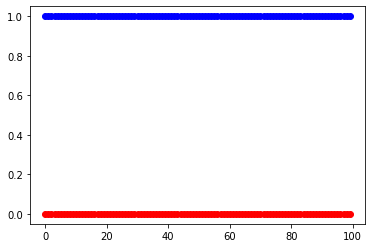

In [36]:
toGraph("1joueur_localrepair_collabpath.txt")

comparer collaborative_path_finding et local_repair sur un seul joueur par équipe:

   iteration  scoreB  scoreR
0          0       1       0
1          1       1       0
2          2       1       0
3          3       1       0
4          4       1       0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

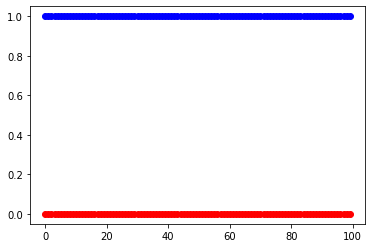

In [35]:
toGraph("1joueur_collabpath_localrepair.txt")

comparer local_repair et minmax sur un seul joueur par équipe:

   iteration  scoreB  scoreR
0          0       1       0
1          1       1       0
2          2       1       1
3          3       1       1
4          4       1       1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0

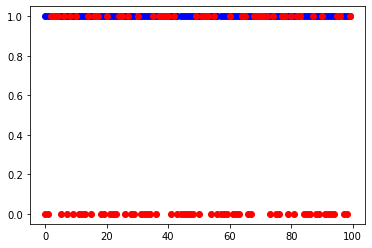

In [34]:
toGraph('1joueur_localrepair_minmax3.txt')



---



---



comparer minmax et minmax sur deux joueurs par équipe:

   iteration  scoreB  scoreR
0          0       2       1
1          1       2       1
2          2       0       2
3          3       1       2
4          4       2       1
[0, 1, 2, 3, 4, 5]
[2, 2, 0, 1, 2, 2]
[1, 1, 2, 2, 1, 1]


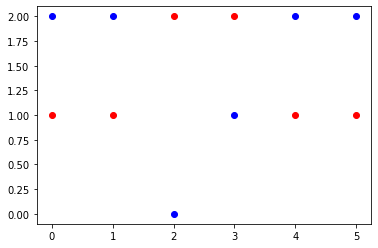

In [33]:
toGraph('2joueur_minmax_minmax.txt')

comparer minmax et local_repair sur deux joueurs par équipe:

   iteration  scoreB  scoreR
0          0       0       2
1          1       2       1
2          2       2       1
3          3       0       2
4          4       2       1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 1, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 0, 2, 0, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 2]
[2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 2

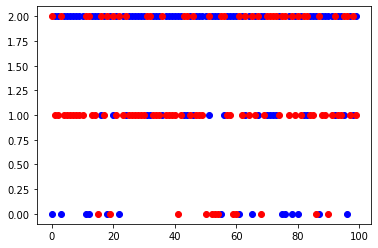

In [32]:
toGraph('2joueur_minmax2_localrepair.txt')

l'equipe bleue l'emporte en moyenne !



---



---



comparer minmax et local_repair sur trois joueurs par équipe:


   iteration  scoreB  scoreR
0          0       2       3
[0]
[2]
[3]


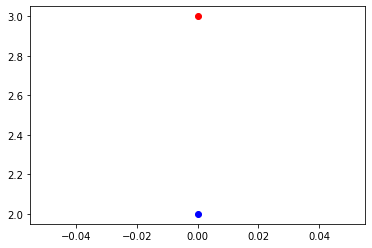

In [27]:
toGraph('3joueur_minmax2_localrepair.txt')

comparer minmax et collab_path_finding sur trois joueurs par équipe:


   iteration  scoreB  scoreR
0          0       0       3
[0]
[0]
[3]


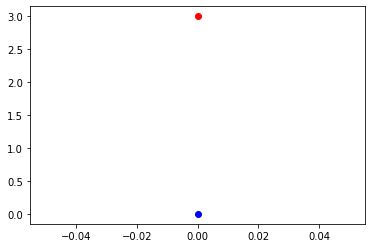

In [29]:
toGraph('3joueur_minmax2_collabpath.txt')



---



---



comparer collaborative_path_finding et local_repair sur 5 joueurs par équipe:

   iteration  scoreB  scoreR
0          0       1       2
1          1       2       1
2          2       2       1
3          3       2       0
4          4       1       2
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 0, 1, 0, 2]
[2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 0]


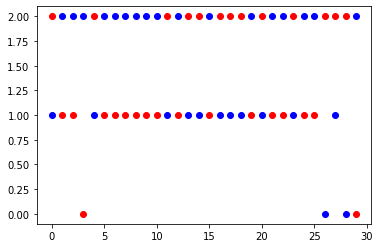

In [37]:
toGraph('5joueur_collapath_localrepair.txt')

on remarque que les deux stratégies sont équivalentes !

on remarque que des fois la victoir est attribuée selon que l'équipe commence !

minmax l'emporte géneralement, mais elle prend beaucoup de temps